In [1]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio
from IPython.display import clear_output
import glob
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
class ShapeLoader:
    def load_shape_from_obj(self, file_path):
        try:
            
            vertices = []
            faces = []
            
            with open(file_path) as f:
                
                for line in f:
                    
#                     print(line)
                    
                    if line.startswith("v "):  # This avoids confusion with vertex normals ("vn")
                        vertex = list(map(float, line[2:].strip().split()))
                        vertices.append(vertex)
                        
#                   elif line.startswith("f "):
#                       face = list(map(int, line[2:].strip().split()))
#                       faces.append(face)

            shape_data = {"vertices": vertices}
#           shape_data = {"vertices": vertices, "faces": faces}

            return shape_data

        except FileNotFoundError:
            print(f"{file_path} not found.")
        except Exception as e:
            print(f"An error occurred while loading the shape: {e}")

# Snapshot

In [165]:
# Create an instance of the class
loader = ShapeLoader()

# Call the method using the instance
base_shape_data_1 = loader.load_shape_from_obj(file_path="Brunei_2023_test_16_1/Brunei_2023_test_16_1/2023_bat_test_16_1_0220.obj")
base_shape_data_2 = loader.load_shape_from_obj(file_path="Brunei_2023_test_16_1/Brunei_2023_test_16_1/2023_bat_test_16_1_0550.obj")

### time step to plot ###
shape_data = loader.load_shape_from_obj(file_path="Brunei_2023_test_16_1/Brunei_2023_test_16_1/2023_bat_test_16_1_0289.obj")

### locations based on time 220 ###
x = np.array(base_shape_data_1["vertices"])[:,0]
y = np.array(base_shape_data_1["vertices"])[:,1]
z = np.array(base_shape_data_1["vertices"])[:,2]

left_ear_index = np.where(x==-0.105841)
right_ear_index = np.where(x==-0.076018)
print(left_ear_index,right_ear_index)

left_wing_tip = np.where(x==-0.186445)
right_wing_tip = np.where(x==0.020125)
print(left_wing_tip,right_wing_tip)

nose = np.where(x==-0.090136)
print(nose)

tail = np.where(x==-0.036686)
print(tail)

### locations based on time 550 ###
x = np.array(base_shape_data_2["vertices"])[:,0]
y = np.array(base_shape_data_2["vertices"])[:,1]
z = np.array(base_shape_data_2["vertices"])[:,2]

left_elbow = np.where(x==-0.07528)
right_elbow = np.where(x==-0.006688)
print(left_wing_tip,right_wing_tip)

(array([1616], dtype=int64),) (array([1607], dtype=int64),)
(array([4981], dtype=int64),) (array([4850], dtype=int64),)
(array([1635], dtype=int64),)
(array([4950], dtype=int64),)
(array([4981], dtype=int64),) (array([4850], dtype=int64),)


In [339]:
### Define vectors to define coordinates ###

### x unit vector ###
x_vec = np.array(shape_data["vertices"])[nose] - np.array(shape_data["vertices"])[tail]
x_unit_vec =  (x_vec/np.sqrt(np.sum(x_vec**2)))[0]

### y unit vector ###
y_vec_1 = np.array(shape_data["vertices"])[left_wing_tip] - np.array(shape_data["vertices"])[right_wing_tip] ### from wing tips
y_vec_2 = np.array(shape_data["vertices"])[left_elbow] - np.array(shape_data["vertices"])[right_elbow] ### from elbows
y_vec = (y_vec_1 + y_vec_2)/2
y_unit_vec = (y_vec/np.sqrt(np.sum(y_vec**2)))[0]

### to ensure perpendicualrity between x and y ###
x_unit_vec_perp = x_unit_vec - np.dot(x_unit_vec,y_unit_vec)*y_unit_vec
x_unit_vec_perp =  (x_unit_vec_perp/np.sqrt(np.sum(x_unit_vec_perp**2)))
x_unit_vec = np.array(x_unit_vec_perp) ### Assign x_unit_vec as the projection of x_unit_vec on the plane perpendicular to y 

### z unit vector (defined as the cross product of the x and y unit vectors) ###
z_vec = np.cross(x_unit_vec,y_unit_vec)[None,:]
z_unit_vec = (z_vec/np.sqrt(np.sum(z_vec**2)))[0]

In [340]:
from scipy.spatial.transform import Rotation as R
import numpy as np

### Define basis vectors ###
base_x = np.array([1,0,0])
base_y = np.array([0,1,0])
base_z = np.array([0,0,1])

# Define the basis vectors of the original frame (e.g., global frame)
global_basis = np.concatenate((base_x[None,:],base_y[None,:],base_z[None,:]),axis=0)

# Define the basis vectors of the target frame (e.g., local frame)
bat_basis = np.concatenate((x_unit_vec[None,:],y_unit_vec[None,:],z_unit_vec[None,:]),axis=0)

# Compute the rotation matrix
rotation, rmsd = R.align_vectors(bat_basis,global_basis)

# Get the rotation matrix
rotation_matrix = rotation.as_matrix()

###
global_rotated_x = rotation_matrix.dot(base_x)
global_rotated_y = rotation_matrix.dot(base_y)
global_rotated_z = rotation_matrix.dot(base_z)

print("Rotation matrix:")
print(rotation_matrix)

Rotation matrix:
[[ 0.32004156 -0.90666971  0.27481526]
 [ 0.93154906  0.24831077 -0.26562775]
 [ 0.17259705  0.34101582  0.92407709]]


In [341]:
### getting the rotation matrix for coordinate transform (using rot_vec) ###
# from scipy.spatial.transform import Rotation as R
# import numpy as np

### define target vector as the x axis in the bat coordinates ###
# target_vector = np.array([y_unit_vec[0],y_unit_vec[1],y_unit_vec[2]])
# base_x = np.array([1,0,0])
# base_y = np.array([0,1,0])
# base_z = np.array([0,0,1])

# theta = np.arccos(np.dot(target_vector,base_y)/(np.linalg.norm(target_vector)*np.linalg.norm(base_y)))
# cross_product = np.cross(base_y,target_vector)
# cross_product = cross_product/np.linalg.norm(cross_product)

# rot_vec = R.from_rotvec(theta*cross_product) 
# rot_mat = rot_vec.as_matrix() 

# global_rotated_x = rot_mat.dot(base_x)
# global_rotated_y = rot_mat.dot(base_y)
# global_rotated_z = rot_mat.dot(base_z)

In [342]:
import plotly.graph_objects as go

# Initialize the figure
fig = go.Figure()

x = np.array(shape_data["vertices"])[:,0]
y = np.array(shape_data["vertices"])[:,1]
z = np.array(shape_data["vertices"])[:,2]

# Add the first 3D scatter plot
fig.add_trace(go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,  # Color based on z-axis values of the first dataset
        colorscale='Viridis',
        opacity=0.8
    ),
    name='Scatter Plot 1'
))

# Add the second 3D scatter plot ears ###
fig.add_trace(go.Scatter3d(
    x=np.stack([ x[left_ear_index],x[right_ear_index] ])[:,0] ,
    y=np.stack([ y[left_ear_index],y[right_ear_index] ])[:,0] ,
    z=np.stack([ z[left_ear_index],z[right_ear_index] ])[:,0] ,
    mode='markers',
    marker=dict(
        size=12,
        color="red",  # Color based on z-axis values of the second dataset
        opacity=0.8
    ),
    name='Scatter Plot 2'
))

# Add the third 3D scatter plot wingtips ###
fig.add_trace(go.Scatter3d(
    x=np.stack([ x[left_wing_tip],x[right_wing_tip] ])[:,0] ,
    y=np.stack([ y[left_wing_tip],y[right_wing_tip] ])[:,0] ,
    z=np.stack([ z[left_wing_tip],z[right_wing_tip] ])[:,0] ,
    mode='markers',
    marker=dict(
        size=12,
        color="purple",  # Color based on z-axis values of the second dataset
        opacity=0.8
    ),
    name='Scatter Plot 2'
))

# Add the fourth 3D scatter plot elbows ###
fig.add_trace(go.Scatter3d(
    x=np.stack([ x[left_elbow],x[right_elbow] ])[:,0] ,
    y=np.stack([ y[left_elbow],y[right_elbow] ])[:,0] ,
    z=np.stack([ z[left_elbow],z[right_elbow] ])[:,0] ,
    mode='markers',
    marker=dict(
        size=12,
        color="purple",  # Color based on z-axis values of the second dataset
        opacity=0.8
    ),
    name='Scatter Plot 2'
))

# Add the fifth 3D scatter plot nose and tail ###
fig.add_trace(go.Scatter3d(
    x=np.stack([ x[nose],x[tail] ])[:,0] ,
    y=np.stack([ y[nose],y[tail] ])[:,0] ,
    z=np.stack([ z[nose],z[tail] ])[:,0] ,
    mode='markers',
    marker=dict(
        size=12,
        color="pink",  # Color based on z-axis values of the second dataset
        opacity=0.8
    ),
    name='Scatter Plot 2'
))

### plot the unit coordinates ###

# Add unit vectors emanating from the nose
nose_coord = np.array([x[nose],y[nose],z[nose]]).reshape(3,)

#Add x_unit_vec
fig.add_trace(go.Scatter3d(
    x=[nose_coord[0], nose_coord[0] + 0.05*x_unit_vec[0]],
    y=[nose_coord[1], nose_coord[1] + 0.05*x_unit_vec[1]],
    z=[nose_coord[2], nose_coord[2] + 0.05*x_unit_vec[2]],
    mode='lines',
    line=dict(
        color='magenta',
        width=7
    ),
    name='X Unit Vector'
))

# # Add y_unit_vec
fig.add_trace(go.Scatter3d(
    x=[nose_coord[0], nose_coord[0] + 0.05*y_unit_vec[0]],
    y=[nose_coord[1], nose_coord[1] + 0.05*y_unit_vec[1]],
    z=[nose_coord[2], nose_coord[2] + 0.05*y_unit_vec[2]],
    mode='lines',
    line=dict(
        color='magenta',
        width=7
    ),
    name='Y Unit Vector'
))

# # Add z_unit_vec
fig.add_trace(go.Scatter3d(
    x=[nose_coord[0], nose_coord[0] + 0.05*z_unit_vec[0]],
    y=[nose_coord[1], nose_coord[1] + 0.05*z_unit_vec[1]],
    z=[nose_coord[2], nose_coord[2] + 0.05*z_unit_vec[2]],
    mode='lines',
    line=dict(
        color='magenta',
        width=7
    ),
    name='Y Unit Vector'
))

## Add Global Coordinate ###
fig.add_trace(go.Scatter3d(
    x=[0,0.25],
    y=[0,0],
    z=[0,0],
    mode='lines',
    line=dict(
        color='black',
        width=7
    ),
    name='x global vector'
))

fig.add_trace(go.Scatter3d(
    x=[0,0],
    y=[0,0.25],
    z=[0,0],
    mode='lines',
    line=dict(
        color='black',
        width=7
    ),
    name='y global vector'
))

fig.add_trace(go.Scatter3d(
    x=[0,0],
    y=[0,0],
    z=[0,0.25],
    mode='lines',
    line=dict(
        color='black',
        width=7
    ),
    name='z global vector'
))


### Global coordinates (rotated but not translated) to the bat fixed coordinates ###
fig.add_trace(go.Scatter3d(
    x=[0,0.25*global_rotated_x[0]],
    y=[0,0.25*global_rotated_x[1]],
    z=[0,0.25*global_rotated_x[2]],
    mode='lines',
    line=dict(
        color='magenta',
        width=7
    ),
    name='x global vector rotated'
))

fig.add_trace(go.Scatter3d(
    x=[0,0.25*global_rotated_y[0]],
    y=[0,0.25*global_rotated_y[1]],
    z=[0,0.25*global_rotated_y[2]],
    mode='lines',
    line=dict(
        color='magenta',
        width=7
    ),
    name='y global vector rotated'
))

fig.add_trace(go.Scatter3d(
    x=[0,0.25*global_rotated_z[0]],
    y=[0,0.25*global_rotated_z[1]],
    z=[0,0.25*global_rotated_z[2]],
    mode='lines',
    line=dict(
        color='magenta',
        width=7,
     
    ),
    name='z global vector rotated'
))


### Global coordinates (rotated and translated) to the bat fixed coordinates ###
fig.add_trace(go.Scatter3d(
    x=[0+nose_coord[0],0.025*global_rotated_x[0]+nose_coord[0]],
    y=[0+nose_coord[1],0.025*global_rotated_x[1]+nose_coord[1]],
    z=[0+nose_coord[2],0.025*global_rotated_x[2]+nose_coord[2]],
    mode='lines',
    line=dict(
        color='orange',
        width=7
    ),
    name='x global vector rotated'
))

fig.add_trace(go.Scatter3d(
    x=[0+nose_coord[0],0.025*global_rotated_y[0]+nose_coord[0]],
    y=[0+nose_coord[1],0.025*global_rotated_y[1]+nose_coord[1]],
    z=[0+nose_coord[2],0.025*global_rotated_y[2]+nose_coord[2]],
    mode='lines',
    line=dict(
        color='orange',
        width=7
    ),
    name='y global vector rotated'
))

fig.add_trace(go.Scatter3d(
    x=[0+nose_coord[0],0.025*global_rotated_z[0]+nose_coord[0]],
    y=[0+nose_coord[1],0.025*global_rotated_z[1]+nose_coord[1]],
    z=[0+nose_coord[2],0.025*global_rotated_z[2]+nose_coord[2]],
    mode='lines',
    line=dict(
        color='orange',
        width=7
    ),
    name='z global vector rotated'
))


#Customize the layout
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title='3D Scatter Plot with Multiple Datasets'
)

# Show the figure
fig.show()

In [343]:
rot_matrix_from_cosines = np.array( [[np.dot(np.array([1,0,0]),x_unit_vec),np.dot(np.array([0,1,0]),x_unit_vec),np.dot(np.array([0,0,1]),x_unit_vec)],
                                     [np.dot(np.array([1,0,0]),y_unit_vec),np.dot(np.array([0,1,0]),y_unit_vec),np.dot(np.array([0,0,1]),y_unit_vec)],
                                     [np.dot(np.array([1,0,0]),z_unit_vec),np.dot(np.array([0,1,0]),z_unit_vec),np.dot(np.array([0,0,1]),z_unit_vec)]])

calculated_x = np.matmul(rot_matrix_from_cosines.T,np.array([1,0,0,])[:,None])
calculated_y = np.matmul(rot_matrix_from_cosines.T,np.array([0,1,0,])[:,None])
calculated_z = np.matmul(rot_matrix_from_cosines.T,np.array([0,0,1,])[:,None])

In [344]:
import numpy as np

def is_rotation_matrix(R, tol=1e-6):
    """
    Check if a matrix R is a valid rotation matrix.
    A valid rotation matrix is orthonormal and has a determinant of 1.
    
    Parameters:
        R (ndarray): 3x3 matrix to check.
        tol (float): Tolerance for numerical comparisons.
    
    Returns:
        bool: True if R is a valid rotation matrix, False otherwise.
    """
    # Check if R is square and 3x3
    if R.shape != (3, 3):
        print("Matrix is not 3x3.")
        return False

    # Check if R.T @ R is close to the identity matrix
    identity = np.eye(3)
    ortho_check = np.allclose(np.dot(R.T, R), identity, atol=tol)
    if not ortho_check:
        print("Matrix is not orthonormal.")
        return False

    # Check if the determinant of R is close to 1
    det = np.linalg.det(R)
    if not np.isclose(det, 1.0, atol=tol):
        print(f"Determinant is not 1 (det = {det}).")
        return False

    # If all checks passed, it's a valid rotation matrix
    return True

print("R_valid is a valid rotation matrix:", is_rotation_matrix(rot_matrix_from_cosines))  # Should be True

R_valid is a valid rotation matrix: True


In [345]:
import numpy as np

def rotation_matrix_to_tait_bryan(R):
    """
    Convert a rotation matrix to Tait-Bryan angles (yaw, pitch, roll).
    Input:
        R - 3x3 rotation matrix
    Output:
        yaw, pitch, roll in radians
    """
    pitch = np.arcsin(-R[2, 0])
    if np.abs(R[2, 0]) != 1:  # Normal case
        print("This is the normal case")
        roll = np.arctan2(R[2, 1], R[2, 2])
        yaw = np.arctan2(R[1, 0], R[0, 0])
    else:  # Gimbal lock case
        yaw = 0  # Arbitrary
        if R[2, 0] == -1:
            pitch = np.pi / 2
            roll = np.arctan2(R[0, 1], R[0, 2])
        else:
            pitch = -np.pi / 2
            roll = np.arctan2(-R[0, 1], -R[0, 2])
    return yaw, pitch, roll

In [346]:
def rot_matrix_by_definition(yaw,pitch,roll):
    
    rot_matrix = np.array([[np.cos(yaw)*np.cos(pitch),-np.sin(yaw)*np.cos(roll)+np.cos(yaw)*np.sin(pitch)*np.sin(roll),
                            np.sin(yaw)*np.sin(roll)+np.cos(yaw)*np.sin(pitch)*np.cos(roll)]
                           
                          ,[np.sin(yaw)*np.cos(pitch),np.cos(yaw)*np.cos(roll)+np.sin(yaw)*np.sin(pitch)*np.sin(roll),
                            -np.cos(yaw)*np.sin(roll)+np.sin(yaw)*np.sin(pitch)*np.cos(roll)]
                          
                          ,[-np.sin(pitch),np.cos(pitch)*np.sin(roll),np.cos(pitch)*np.cos(roll)]])
    
    return rot_matrix

In [347]:
yaw,pitch,roll = rotation_matrix_to_tait_bryan(rot_matrix_from_cosines)
# yaw = np.arcsin(-0.92023963/np.cos(pitch))

r_z = np.array([[np.cos(yaw),-np.sin(yaw),0]
               ,[np.sin(yaw),np.cos(yaw),0]
               ,[0,0,1]])

r_y = np.array([[np.cos(pitch),0,np.sin(pitch)]
               ,[0,1,0]
               ,[-np.sin(pitch),0,np.cos(pitch)]])

r_x = np.array([[1,0,0]
               ,[0,np.cos(roll),-np.sin(roll)]
               ,[0,np.sin(roll),np.cos(roll)]])

calculated_x_only_yaw = np.matmul(r_z.T,np.array([1,0,0,])[:,None])
calculated_y_only_yaw = np.matmul(r_z.T,np.array([0,1,0,])[:,None])
calculated_z_only_yaw = np.matmul(r_z.T,np.array([0,0,1,])[:,None])

calculated_x_pitch_yaw = np.matmul(r_y.T,calculated_x_only_yaw)
calculated_y_pitch_yaw = np.matmul(r_y.T,calculated_y_only_yaw)
calculated_z_pitch_yaw = np.matmul(r_y.T,calculated_z_only_yaw)

calculated_x_roll_pitch_yaw = np.matmul(r_x.T,calculated_x_pitch_yaw)
calculated_y_roll_pitch_yaw = np.matmul(r_x.T,calculated_y_pitch_yaw)
calculated_z_roll_pitch_yaw = np.matmul(r_x.T,calculated_z_pitch_yaw)

This is the normal case


In [348]:
rot_matrix_from_cosines

array([[ 0.32004156,  0.93154906,  0.17259705],
       [-0.90666971,  0.24831077,  0.34101582],
       [ 0.27481526, -0.26562775,  0.92407709]])

In [349]:
rot_matrix_by_definition(yaw,pitch,roll)

array([[ 0.32004156,  0.93154906,  0.17259705],
       [-0.90666971,  0.24831077,  0.34101582],
       [ 0.27481526, -0.26562775,  0.92407709]])

In [350]:
rot_matrix_from_cosines - rot_matrix_by_definition(yaw,pitch,roll)

array([[-1.11022302e-16,  1.11022302e-16,  5.55111512e-17],
       [-1.11022302e-16, -5.55111512e-17,  0.00000000e+00],
       [ 0.00000000e+00, -5.55111512e-17,  2.22044605e-16]])

In [351]:
fig = go.Figure()


## Add Global Coordinate ###
fig.add_trace(go.Scatter3d(
    x=[0,0.25],
    y=[0,0],
    z=[0,0],
    mode='lines',
    line=dict(
        color='red',
        width=7
    ),
    name='x global vector'
))

fig.add_trace(go.Scatter3d(
    x=[0,0],
    y=[0,0.25],
    z=[0,0],
    mode='lines',
    line=dict(
        color='green',
        width=7
    ),
    name='y global vector'
))

fig.add_trace(go.Scatter3d(
    x=[0,0],
    y=[0,0],
    z=[0,0.25],
    mode='lines',
    line=dict(
        color='blue',
        width=7
    ),
    name='z global vector'
))

### Bat frame on the origin (translated to the orgin)###
fig.add_trace(go.Scatter3d(
    x=[0,0.25*x_unit_vec[0]],
    y=[0,0.25*x_unit_vec[1]],
    z=[0,0.25*x_unit_vec[2]],
    mode='lines',
    line=dict(
        color='magenta',
        width=7
    ),
    name='x derived from bat fixed coordinate'
))

fig.add_trace(go.Scatter3d(
    x=[0,0.25*y_unit_vec[0]],
    y=[0,0.25*y_unit_vec[1]],
    z=[0,0.25*y_unit_vec[2]],
    mode='lines',
    line=dict(
        color='magenta',
        width=7
    ),
    name='y derived from bat fixed coordinate'
))

fig.add_trace(go.Scatter3d(
    x=[0,0.25*z_unit_vec[0]],
    y=[0,0.25*z_unit_vec[1]],
    z=[0,0.25*z_unit_vec[2]],
    mode='lines',
    line=dict(
        color='magenta',
        width=7
    ),
    name='z derived from bat fixed coordinate'
))


### Frame obtaoined by rotating the global frame (using scipy) ###
# fig.add_trace(go.Scatter3d(
#     x=[0,0.15*global_rotated_x[0]],
#     y=[0,0.15*global_rotated_x[1]],
#     z=[0,0.15*global_rotated_x[2]],
#     mode='lines',
#     line=dict(
#         color='green',
#         width=20
#     ),
#     name='x derived from bat fixed coordinate'
# ))

# fig.add_trace(go.Scatter3d(
#     x=[0,0.15*global_rotated_y[0]],
#     y=[0,0.15*global_rotated_y[1]],
#     z=[0,0.15*global_rotated_y[2]],
#     mode='lines',
#     line=dict(
#         color='green',
#         width=20
#     ),
#     name='y derived from bat fixed coordinate'
# ))

# fig.add_trace(go.Scatter3d(
#     x=[0,0.15*global_rotated_z[0]],
#     y=[0,0.15*global_rotated_z[1]],
#     z=[0,0.15*global_rotated_z[2]],
#     mode='lines',
#     line=dict(
#         color='green',
#         width=20
#     ),
#     name='z derived from bat fixed coordinate'
# ))


## Frame obtaoined by rotating the global frame (using rotation matrix calculations) ###
fig.add_trace(go.Scatter3d(
    x=[0,0.15*calculated_x[0][0]],
    y=[0,0.15*calculated_x[1][0]],
    z=[0,0.15*calculated_x[2][0]],
    mode='lines',
    line=dict(
        color='red',
        width=20
    ),
    name='x by rotating global coordinated'
))

fig.add_trace(go.Scatter3d(
    x=[0,0.15*calculated_y[0][0]],
    y=[0,0.15*calculated_y[1][0]],
    z=[0,0.15*calculated_y[2][0]],
    mode='lines',
    line=dict(
        color='green',
        width=20
    ),
    name='y by rotating global coordinated'
))

fig.add_trace(go.Scatter3d(
    x=[0,0.15*calculated_z[0][0]],
    y=[0,0.15*calculated_z[1][0]],
    z=[0,0.15*calculated_z[2][0]],
    mode='lines',
    line=dict(
        color='blue',
        width=20
    ),
    name='z by rotating global coordinated'
))


## Frame obtaoined by rotating the global frame (using rotation matrix only yaw) ###
# fig.add_trace(go.Scatter3d(
#     x=[0,0.15*calculated_x_only_yaw[0][0]],
#     y=[0,0.15*calculated_x_only_yaw[1][0]],
#     z=[0,0.15*calculated_x_only_yaw[2][0]],
#     mode='lines',
#     line=dict(
#         color='red',
#         width=20
#     ),
#     name='x by rotating global coordinated only yaw'
# ))

# fig.add_trace(go.Scatter3d(
#     x=[0,0.15*calculated_y_only_yaw[0][0]],
#     y=[0,0.15*calculated_y_only_yaw[1][0]],
#     z=[0,0.15*calculated_y_only_yaw[2][0]],
#     mode='lines',
#     line=dict(
#         color='green',
#         width=20
#     ),
#     name='y by rotating global coordinated only yaw'
# ))

# fig.add_trace(go.Scatter3d(
#     x=[0,0.15*calculated_z_only_yaw[0][0]],
#     y=[0,0.15*calculated_z_only_yaw[1][0]],
#     z=[0,0.15*calculated_z_only_yaw[2][0]],
#     mode='lines',
#     line=dict(
#         color='blue',
#         width=20
#     ),
#     name='z by rotating global coordinated only yaw'
# ))

# ## Frame obtaoined by rotating the global frame (using rotation matrix pitch and yaw) ###
# fig.add_trace(go.Scatter3d(
#     x=[0,0.15*calculated_x_pitch_yaw[0][0]],
#     y=[0,0.15*calculated_x_pitch_yaw[1][0]],
#     z=[0,0.15*calculated_x_pitch_yaw[2][0]],
#     mode='lines',
#     line=dict(
#         color='purple',
#         width=20
#     ),
#     name='x by rotating global coordinated pitch and yaw'
# ))

# fig.add_trace(go.Scatter3d(
#     x=[0,0.15*calculated_y_pitch_yaw[0][0]],
#     y=[0,0.15*calculated_y_pitch_yaw[1][0]],
#     z=[0,0.15*calculated_y_pitch_yaw[2][0]],
#     mode='lines',
#     line=dict(
#         color='purple',
#         width=20
#     ),
#     name='y by rotating global coordinated pitch and yaw'
# ))

# fig.add_trace(go.Scatter3d(
#     x=[0,0.15*calculated_z_pitch_yaw[0][0]],
#     y=[0,0.15*calculated_z_pitch_yaw[1][0]],
#     z=[0,0.15*calculated_z_pitch_yaw[2][0]],
#     mode='lines',
#     line=dict(
#         color='purple',
#         width=20
#     ),
#     name='z by rotating global coordinated pitch and yaw'
# ))


# ## Frame obtaoined by rotating the global frame (using rotation matrix pitch and yaw) ###
# fig.add_trace(go.Scatter3d(
#     x=[0,0.15*calculated_x_pitch_yaw[0][0]],
#     y=[0,0.15*calculated_x_pitch_yaw[1][0]],
#     z=[0,0.15*calculated_x_pitch_yaw[2][0]],
#     mode='lines',
#     line=dict(
#         color='purple',
#         width=20
#     ),
#     name='x by rotating global coordinated pitch and yaw'
# ))

# fig.add_trace(go.Scatter3d(
#     x=[0,0.15*calculated_y_pitch_yaw[0][0]],
#     y=[0,0.15*calculated_y_pitch_yaw[1][0]],
#     z=[0,0.15*calculated_y_pitch_yaw[2][0]],
#     mode='lines',
#     line=dict(
#         color='purple',
#         width=20
#     ),
#     name='y by rotating global coordinated pitch and yaw'
# ))

# fig.add_trace(go.Scatter3d(
#     x=[0,0.15*calculated_z_pitch_yaw[0][0]],
#     y=[0,0.15*calculated_z_pitch_yaw[1][0]],
#     z=[0,0.15*calculated_z_pitch_yaw[2][0]],
#     mode='lines',
#     line=dict(
#         color='purple',
#         width=20
#     ),
#     name='z by rotating global coordinated pitch and yaw'
# ))

## Frame obtained by rotating the global frame (using rotation matrix roll,pitch and yaw) ###
fig.add_trace(go.Scatter3d(
    x=[0,0.10*calculated_x_roll_pitch_yaw[0][0]],
    y=[0,0.10*calculated_x_roll_pitch_yaw[1][0]],
    z=[0,0.10*calculated_x_roll_pitch_yaw[2][0]],
    mode='lines',
    line=dict(
        color='red',
        width=40
    ),
    name='x by rotating global coordinated roll,pitch and yaw'
))

fig.add_trace(go.Scatter3d(
    x=[0,0.10*calculated_y_roll_pitch_yaw[0][0]],
    y=[0,0.10*calculated_y_roll_pitch_yaw[1][0]],
    z=[0,0.10*calculated_y_roll_pitch_yaw[2][0]],
    mode='lines',
    line=dict(
        color='green',
        width=40
    ),
    name='y by rotating global coordinated roll,pitch and yaw'
))

fig.add_trace(go.Scatter3d(
    x=[0,0.10*calculated_z_roll_pitch_yaw[0][0]],
    y=[0,0.10*calculated_z_roll_pitch_yaw[1][0]],
    z=[0,0.10*calculated_z_roll_pitch_yaw[2][0]],
    mode='lines',
    line=dict(
        color='blue',
        width=40
    ),
    name='z by rotating global coordinated roll,pitch and yaw'
))

# Movie

In [ ]:
### 16_1 ###
loader = ShapeLoader()

shape_data_list = list()

start_time = 210
end_time = 890

for i in range(start_time,end_time+1):
    
    print("Currently on timestep = ",str(i))
    shape_data = loader.load_shape_from_obj(file_path="Brunei_2023_test_16_1/Brunei_2023_test_16_1/2023_bat_test_16_1_0"+str(i)+".obj")
    
    if shape_data is None:
        
        print("This times step",str(i+1),"is none datatype")
        continue
    
    shape_data_list.append(shape_data)
    clear_output(wait=True)

In [ ]:
### 13_1 ###
loader = ShapeLoader()

shape_data_list = list()

start_time = 490
end_time = 1410

for i in range(start_time,end_time+1):
    
    if i<=999:
        
        print("Currently on timestep = ",str(i))
        shape_data = loader.load_shape_from_obj(file_path="Brunei_2023_test_13_1/Brunei_2023_test_13_1/2023_bat_13_1_0"+str(i)+".obj")
        
    if i>999:
        
        print("Currently on timestep = ",str(i))
        shape_data = loader.load_shape_from_obj(file_path="Brunei_2023_test_13_1/Brunei_2023_test_13_1/2023_bat_13_1_"+str(i)+".obj")
    
    if shape_data is None:
        
        print("This times step",str(i+1),"is none datatype")
        continue
    
    shape_data_list.append(shape_data)
#     clear_output(wait=True)

Text(0.5, 0, 'Z Axis')

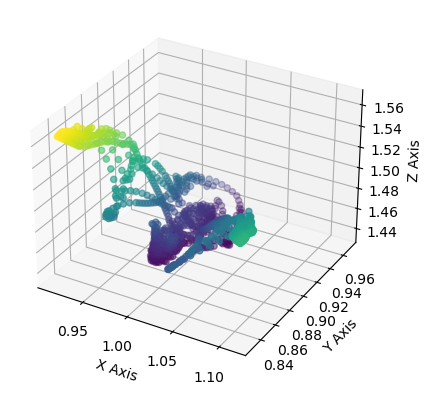

In [24]:
data = np.array(shape_data_list[0]["vertices"])
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
    
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

# Set axis labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

In [19]:
len(shape_data_list)

411

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example shape_data_list with synthetic data for demonstration
# shape_data_list = [np.random.rand(100, 3) for _ in range(start_time, end_time + 1)]
single_point = list()

for i in range(len(shape_data_list)):
    print("Currently on timestep =", str(i))
    
    # Retrieve 3D coordinates for the current timestep
    data = np.array(shape_data_list[i]["vertices"])
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

    # Set axis labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')

    # Set the aspect ratio to be equal in all directions
#     ax.set_box_aspect([1,1,1])  # aspect ratio is 1:1:1
    
    ### set box limits ###
    ax.set_xlim([0.65,1.3])
    ax.set_ylim([-1.65,1.1])
    ax.set_zlim([1.2,1.6])
    
    # Save the plot as an image file
    image_filename = f"scatter_plots/image_{i:04d}.png"
    plt.savefig(image_filename)
    plt.close(fig)  # Close the figure to avoid display
    
#     if i==10:
#         break

print("All images have been saved.")

Currently on timestep = 0
Currently on timestep = 1
Currently on timestep = 2
Currently on timestep = 3
Currently on timestep = 4
Currently on timestep = 5
Currently on timestep = 6
Currently on timestep = 7
Currently on timestep = 8
Currently on timestep = 9
Currently on timestep = 10
Currently on timestep = 11
Currently on timestep = 12
Currently on timestep = 13
Currently on timestep = 14
Currently on timestep = 15
Currently on timestep = 16
Currently on timestep = 17
Currently on timestep = 18
Currently on timestep = 19
Currently on timestep = 20
Currently on timestep = 21
Currently on timestep = 22
Currently on timestep = 23
Currently on timestep = 24
Currently on timestep = 25
Currently on timestep = 26
Currently on timestep = 27
Currently on timestep = 28
Currently on timestep = 29
Currently on timestep = 30
Currently on timestep = 31
Currently on timestep = 32
Currently on timestep = 33
Currently on timestep = 34
Currently on timestep = 35
Currently on timestep = 36
Currently o

Currently on timestep = 297
Currently on timestep = 298
Currently on timestep = 299
Currently on timestep = 300
Currently on timestep = 301
Currently on timestep = 302
Currently on timestep = 303
Currently on timestep = 304
Currently on timestep = 305
Currently on timestep = 306
Currently on timestep = 307
Currently on timestep = 308
Currently on timestep = 309
Currently on timestep = 310
Currently on timestep = 311
Currently on timestep = 312
Currently on timestep = 313
Currently on timestep = 314
Currently on timestep = 315
Currently on timestep = 316
Currently on timestep = 317
Currently on timestep = 318
Currently on timestep = 319
Currently on timestep = 320
Currently on timestep = 321
Currently on timestep = 322
Currently on timestep = 323
Currently on timestep = 324
Currently on timestep = 325
Currently on timestep = 326
Currently on timestep = 327
Currently on timestep = 328
Currently on timestep = 329
Currently on timestep = 330
Currently on timestep = 331
Currently on timeste

Currently on timestep = 590
Currently on timestep = 591
Currently on timestep = 592
Currently on timestep = 593
Currently on timestep = 594
Currently on timestep = 595
Currently on timestep = 596
Currently on timestep = 597
Currently on timestep = 598
Currently on timestep = 599
Currently on timestep = 600
Currently on timestep = 601
Currently on timestep = 602
Currently on timestep = 603
Currently on timestep = 604
Currently on timestep = 605
Currently on timestep = 606
Currently on timestep = 607
Currently on timestep = 608
Currently on timestep = 609
Currently on timestep = 610
Currently on timestep = 611
Currently on timestep = 612
Currently on timestep = 613
Currently on timestep = 614
Currently on timestep = 615
Currently on timestep = 616
Currently on timestep = 617
Currently on timestep = 618
Currently on timestep = 619
Currently on timestep = 620
Currently on timestep = 621
Currently on timestep = 622
Currently on timestep = 623
Currently on timestep = 624
Currently on timeste

Currently on timestep = 883
Currently on timestep = 884
Currently on timestep = 885
Currently on timestep = 886
Currently on timestep = 887
Currently on timestep = 888
Currently on timestep = 889
Currently on timestep = 890
Currently on timestep = 891
Currently on timestep = 892
Currently on timestep = 893
Currently on timestep = 894
Currently on timestep = 895
Currently on timestep = 896
Currently on timestep = 897
Currently on timestep = 898
Currently on timestep = 899
Currently on timestep = 900
Currently on timestep = 901
Currently on timestep = 902
Currently on timestep = 903
Currently on timestep = 904
Currently on timestep = 905
Currently on timestep = 906
Currently on timestep = 907
Currently on timestep = 908
Currently on timestep = 909
Currently on timestep = 910
Currently on timestep = 911
Currently on timestep = 912
Currently on timestep = 913
Currently on timestep = 914
Currently on timestep = 915
Currently on timestep = 916
Currently on timestep = 917
Currently on timeste

In [26]:
### Get x,y,z limits of the domain ###
x_all = [np.array(shape_data_list[i]["vertices"])[:,0] for i in range(len(shape_data_list))]
y_all = [np.array(shape_data_list[i]["vertices"])[:,1] for i in range(len(shape_data_list))]
z_all = [np.array(shape_data_list[i]["vertices"])[:,2] for i in range(len(shape_data_list))]

print( np.stack(x_all).min() , np.stack(x_all).max() )
print( np.stack(y_all).min() , np.stack(y_all).max() )
print( np.stack(z_all).min() , np.stack(z_all).max() )

0.703432 1.2092
-1.592291 0.984848
1.262117 1.630258


In [31]:
### Make video from scatter plot images ###
def list_png_files(directory):
    # Create a pattern to match .png files
    pattern = os.path.join(directory, "*.png")
    # List all files matching the pattern
    png_files = glob.glob(pattern)
    return png_files

def images_to_video(image_paths, output_video_path, frame_rate=30):
    # Check if the list of images is not empty
    if not image_paths:
        raise ValueError("The list of image paths is empty.")

    # Read the first image to get the size (width and height)
    first_image = cv2.imread(image_paths[0])
    if first_image is None:
        raise ValueError(f"Image at path {image_paths[0]} could not be loaded.")
    
    height, width, _ = first_image.shape

    # Create a video writer object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
    video_writer = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (width, height))

    # Write each image to the video
    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Image at path {image_path} could not be loaded.")
            continue

        # Resize the image to match the video size if needed
        img = cv2.resize(img, (width, height))
        video_writer.write(img)

    # Release the video writer object
    video_writer.release()
    print(f"Video saved at {output_video_path}")
    
    return video_writer
    
image_paths = list_png_files("scatter_plots/")
output_video_path = "videos/v3/Brunei_2023_test_13_1.mp4"
video_writer = images_to_video(image_paths, output_video_path)

Video saved at videos/v3/Brunei_2023_test_13_1.mp4


In [ ]:
### Interactive HTML 3D plot ###

import numpy as np
import plotly.graph_objects as go

# Example list of NumPy arrays for each timestep
# n = 10  # Number of particles
# timesteps = 50  # Number of timesteps

sample_points = np.random.randint(0,len(shape_data_list[0]["vertices"]),500)
# Create some random data for demonstration purposes
# data = [np.random.rand(n, 3) for _ in range(timesteps)]
data = [ np.array(shape_data_list[i]["vertices"]) for i in range(len(shape_data_list)) ]
timesteps = len(data)

# Calculate the min and max for all coordinates to set axis limits
all_data = np.vstack(data)  # Stack all timesteps to find global min/max
x_min, y_min, z_min = all_data.min(axis=0)
x_max, y_max, z_max = all_data.max(axis=0)

# x_min, y_min, z_min = -2,-0.25,-0.25
# x_max, y_max, z_max = 2,0.25,0.75

# Create frames for animation
frames = []

for i in range(timesteps):
    frame = go.Frame(
        data=[
            go.Scatter3d(
                
                x=data[i][:, 0],
                y=data[i][:, 1],
                z=data[i][:, 2],
                
                mode="markers",
                marker=dict(size=5, color=np.linspace(0, 1, len(data[i])), colorscale="Viridis")
            )
        ],
        name=f"frame_{i}"
    )
    frames.append(frame)

# Create slider steps
slider_steps = [
    {
        "args": [
            [f"frame_{i}"],
            {
                "frame": {"duration": 100, "redraw": True},
                "mode": "immediate",
                "transition": {"duration": 0},
            },
        ],
        "label": str(i),
        "method": "animate",
    }
    for i in range(timesteps)
]

# Create the figure
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=data[0][:, 0],
            y=data[0][:, 1],
            z=data[0][:, 2],
            mode="markers",
            marker=dict(size=5, color=np.linspace(0, 1, len(data[i])), colorscale="Viridis")
        )
    ],
    layout=go.Layout(
        title="3D Particle Animation with Slider",
        scene=dict(
            xaxis=dict(range=[x_min, x_max], autorange=False),
            yaxis=dict(range=[y_min, y_max], autorange=False),
            zaxis=dict(range=[z_min, z_max], autorange=False),
            aspectmode='cube',  # Ensures equal aspect ratio in all directions
        ),
        updatemenus=[
            dict(
                type="buttons",
                showactive=False,
                buttons=[
                    dict(
                        label="Play",
                        method="animate",
                        args=[
                            None,
                            dict(
                                frame=dict(duration=100, redraw=True),
                                fromcurrent=True,
                                mode="immediate"
                            )
                        ]
                    ),
                    dict(
                        label="Pause",
                        method="animate",
                        args=[[None], dict(frame=dict(duration=0, redraw=False), mode="immediate")]
                    )
                ]
            )
        ],
        sliders=[{
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {
                "font": {"size": 20},
                "prefix": "Time: ",
                "visible": True,
                "xanchor": "right"
            },
            "transition": {"duration": 100, "easing": "linear"},
            "pad": {"b": 10, "t": 50},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "steps": slider_steps
        }]
    ),
    frames=frames
)

# Show the plot in an HTML file
fig.write_html("videos/v2/15_2_w_wingthickness.html", auto_play=False)

# Optionally, display the plot inline in a Jupyter Notebook (if using a notebook)
# fig.show()

# Path Trajectories

In [ ]:
### 15_1 ###
single_point = [np.mean(shape_data_list[i]["vertices"],axis=0) for i in range(len(shape_data_list))]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(np.stack(single_point)[:,0],np.stack(single_point)[:,1],np.stack(single_point)[:,2])

In [ ]:
### 15_2 ###
single_point = [np.mean(shape_data_list[i]["vertices"],axis=0) for i in range(len(shape_data_list))]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(np.stack(single_point)[:,0],np.stack(single_point)[:,1],np.stack(single_point)[:,2])

In [ ]:
### 17_1 ###
single_point = [np.mean(shape_data_list[i]["vertices"],axis=0) for i in range(len(shape_data_list))]

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(np.stack(single_point)[:,0],np.stack(single_point)[:,1],np.stack(single_point)[:,2])